<a href="https://colab.research.google.com/github/prajwalshrestha381/Thinkful_Data_Analytics/blob/main/Python_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Testing the efficacy of using Price Earnings Ratio and 10-year Treasury rates to maximize returns on S&P 500 index over a medium term horizon.**

Over the past 30 years, the S&P 500 index has delivered a compound average annual growth rate of 10.7% per year. While this a relatively attractive return on investment, the actual returns tend to vary based upon the timing of the investment—e.g.,the S&P 500 index delivered a five-year return of -6.6% a year over the five years ending in February 2009, while it delivered a return of 30% a year over the five years ending in July 1987.

Hence, to determine an optimal point of entry Two Sample t-Tests will be conducted using: S&P 500 price earnings ratio (PE Ratio) and year-over-year percentage change in 10-year treasury yield  (DGS10) as independent variables, and 5yr forward return on S&P 500 as dependent variable.

The first variable, PE ratio, is selected to test the age old adage of "Buy low, Sell High." A straight-forward measure calculated by dividing the price by earnings, this ratio acts as a metric showing how expensive the index is with repect to its earnigns. 

The second variable, 10-year treasury yield is a closely watched as an indicator of broader investor confidence. The 10-year is used as a proxy for many other important financial matters, such as mortgage rates. This bond also tends to signal investor confidence. The U.S Treasury sells bonds via auction and yields are set through a bidding process.5 When confidence is high, prices for the 10-year drop, and yields rise. 


The test will be done in three stages; gathering data, cleaning the data, and testing and analyzing the results.



## **1. Gathering and Loading the Data**



### **Setting up all the tools**
First we need to import all the tools required for this study. Here, we install the API client that will be used to gather data; pandas, numpy, statsmodels and scipy packages for data manipulation and analysis; and matplotlib and seaborn for data visualization.


In [30]:
# Import all packages
!pip install -U ipython 
!pip install quandl
!pip install termcolor
from termcolor import colored
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import math
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
import scipy.stats as sp
from datetime import datetime
from scipy.stats import ttest_ind as ttest
from IPython.core.interactiveshell import InteractiveShell

# Suppress warnings (warnings do not prevent the code from executing)
import warnings
warnings.filterwarnings("ignore")



### **Loading the data**

Now we load the data for the study from two primary sources:
1) Quandl financial database using Quandl API to get PE ratio data and price data for S&P 500.
2) The Federal Reseve Econmic System (FRED) database to get the M2 money stock and 10-year Treasury yields. For convinience this data has been downloaded in excel format and loaded to the module. Link to the files is available here:

https://drive.google.com/file/d/1ok9Ciu6s9PdtuKrkwJxsjsWjhB4eaUis/view?usp=sharing https://drive.google.com/file/d/19naOYgjC58EPWtPexqxW8pKP0XXG0igc/view?usp=sharing


In [19]:
#mounting data from drive 
from google.colab import drive
drive.mount('/content/gdrive')

# importing data
quandl.ApiConfig.api_key = "zxh5qxSPXXjvGSrsgmBT"
df = quandl.get("MULTPL/SP500_PE_RATIO_MONTH", authtoken="zxh5qxSPXXjvGSrsgmBT")
df["Close"] = quandl.get("MULTPL/SP500_REAL_PRICE_MONTH")
df1 = pd.read_excel (r'/content/gdrive/My Drive/Colab Notebooks/DGS10.xls')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).



## **2. Cleaning and Preparing the Data for Analysis**

In this step the data from different sources is aggregated into a single dataframe, formatted and cleaned, and prepared for analysis. 



### **Conslidating the data into single dataset**


In [20]:
# Formating the datasets and merging it into one dataframe
df1['Date'] = df1['observation_date']
df.rename(columns={"Value":"PE_Ratio"}, inplace=True)
df.reset_index(inplace=True)
df = pd.merge(df, df1, on ="Date")
df.drop('observation_date', axis=1, inplace=True)
df.head()


,Date,PE_Ratio,Close,DGS10
0,1962-01-01,21.25,69.07,4.083182
1,1962-02-01,21.21,70.22,4.039444
2,1962-03-01,20.86,70.29,3.930455
3,1962-04-01,20.00,68.05,3.843000
4,1962-05-01,18.33,62.99,3.873636



Now that the datasets have been consolidated, we create some calculated columns to test our hypothesis. In that, given that two independent variables the study is testing are continious they will be converted into categorical variables. PE ratio will be categorized into low PE (PE ratio of less than or equal to 14) and high PE (PE ratio of more than or equal to 22) and the 10-year treasury yeilds will be categorized into increasing and decreasing regimes. As such, this categorization not only makes the testing possible, but will also provide investors with charateristic market scenarios wherein it is more profitable to invest (if in fact the study finds statistically significant relationship between the respective pairs of independent variables and the dependent variable.)



### **Adding calulated columns for running t-Tests**


In [21]:
# Calculate 5 year forward return
df['five_yr_fr'] =  (df['Close'].shift(-60)-df['Close'])/df['Close'] 

# Convert independent variables into categorical variables
conditions = [
    (df['PE_Ratio']<= 14),
    (df['PE_Ratio'] > 14) & (df['PE_Ratio'] <= 22),
    (df['PE_Ratio'] >22)
]
values = ['low','avg','high']
df['peratio']=np.select(conditions, values)

df['DGS10_yoy_chng'] = df.DGS10.diff(12)
conditions = [
    (df['DGS10_yoy_chng']< 0),
    (df['DGS10_yoy_chng'] > 0)
]
values = ['decreasing','increasing']
df['DGS10_yoy_chng']=np.select(conditions, values)



### **Handling null value**

Missing data, by nature, is problematic. Whenever we’re using our historical data to gain insight, we want to make sure that our sample population is as representative of our actual population as possible. By determining the source of missingness in our datasets, we can more accurately decide how to handle missing values to improve model quality.

Null values generally fall into one of two categories: values that are missing at random, and those values that are not missing at random. Given the nature and source of our initial data, it is complete and there are no missing values. However, as the method of testing here involves calculated columns that look 5 years forward, it inevitably creates null values at the end of dataframe. Hence, we remove these null values. 


In [22]:
null_rows = df[df.isnull().any(axis=1)]
null_rows.info()
df.dropna(inplace=True)
df.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 655 to 714
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            60 non-null     datetime64[ns]
 1   PE_Ratio        60 non-null     float64       
 2   Close           60 non-null     float64       
 3   DGS10           59 non-null     float64       
 4   five_yr_fr      0 non-null      float64       
 5   peratio         60 non-null     object        
 6   DGS10_yoy_chng  60 non-null     object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 3.8+ KB


,Date,PE_Ratio,Close,DGS10,five_yr_fr,peratio,DGS10_yoy_chng
650,2016-03-01,23.39,2021.95,1.889091,0.934029,high,decreasing
651,2016-04-01,23.97,2075.54,1.805238,0.995230,high,decreasing
652,2016-05-01,23.81,2065.55,1.806190,1.017792,high,decreasing
653,2016-06-01,23.97,2083.89,1.644091,1.033932,high,decreasing
654,2016-07-01,24.52,2148.90,1.504000,1.010303,high,decreasing



As we can see in the results above, a total of 60 null values have been detected and removed.



### **Removing outliers**

The final step for preparing the data for analysis involves removing the outliers. The importance of removing the outliers for any statistical analysis cannot be overstated as they tend to siginificantly skew the resutls of the study. So, we first calculate the descriptive statistics to gather simple summaries about the sample and the measures, then we identify and remove the outliers using Z score method. As matter of standard practice, only those data points that fall under the 3 standard deviations will be used for the study.


In [24]:
df[['PE_Ratio','DGS10']].describe() 

,PE_Ratio,DGS10
count,655.000000,655.000000
mean,18.948748,6.353002
std,12.116550,2.827341
min,6.790000,1.504000
25%,13.710000,4.207598
50%,17.570000,6.068636
75%,20.735000,7.861158
max,123.730000,15.323810



Looking at the descriptive statistics: we have sufficiently large sample size of 655; and PE_Ratio and DGS10 appear to be relatively normally distributed. Now we futher asses the shape and spread of data using histogram.


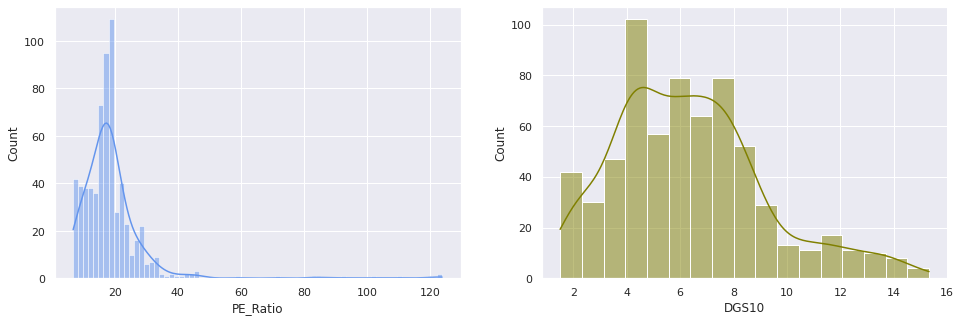

In [25]:
# Check distribution
sns.set(style="darkgrid")

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,figsize=(16, 5))
sns.histplot(data=df, x="PE_Ratio", kde=True, color="cornflowerblue", ax=ax0)
sns.histplot(data=df, x="DGS10", kde=True, color="olive", ax=ax1)
plt.show()


As discussed above, the histogram plot confirms our prior conclusion of PE_Ratio and DGS10 being relatively normally distributed. Moving on, we use box plot to get a picture of the outliers and then remove the outliers so as to run a more statistically sound test.


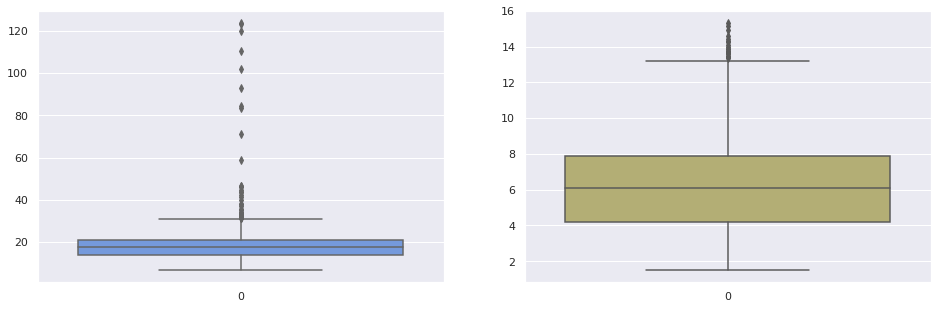

In [26]:
sns.set(style="darkgrid")

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,figsize=(16, 5))
sns.boxplot(data=df['PE_Ratio'], color = "cornflowerblue", ax =ax0)
sns.boxplot(data=df['DGS10'], color = "darkkhaki", ax =ax1)
plt.show()


As we can see in the boxplots above there are significant number of outliers in the first variable. So we remove them using the Z score method.


,PE_Ratio,Close,DGS10,five_yr_fr
count,642.000000,642.000000,642.000000,642.000000
mean,17.784377,595.535327,6.362447,0.458228
std,6.759486,590.735122,2.761845,0.488855
min,6.790000,55.630000,1.504000,-0.326385
25%,13.700000,100.700000,4.231250,0.042533
50%,17.510000,301.850000,6.109409,0.451770
75%,20.140000,1131.810000,7.861261,0.722548
max,46.710000,2148.900000,14.594000,2.138645


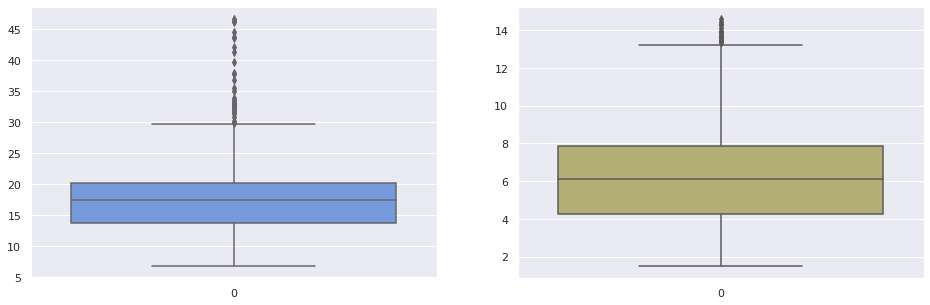

In [27]:
# Remove the outliers
z_scores = stats.zscore(df['PE_Ratio'])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3)
df = df[filtered_entries]

z_scores = stats.zscore(df['DGS10'])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3)
df = df[filtered_entries]

# Configure notebook to display output of every
%config InteractiveShell.ast_node_interactivity = 'all'

# Get descriptive statistics for cleaned dataset
df.describe()

# Get Boxplots for cleaned data
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,figsize=(16, 5))
sns.boxplot(data=df['PE_Ratio'], color = "cornflowerblue", ax =ax0)
sns.boxplot(data=df['DGS10'], color = "darkkhaki", ax =ax1)
plt.show()


A total of 13 outliers have been removed, leaving us we with ample and relatively more statistically sound final dataset to run our tests.



## **3. Two-Sample t-Tests**

Now that we have the data consolidated, cleaned and properly formatted we can run the t-tests. In following section two hypotheses will be tested:

    i) Ho: The mean 5-year forward return for S&P 500 during low PE ratio = The mean 5-year forward return for S&P 500 during low PE ratio

    Ha: The mean 5-year forward return for S&P 500 during low PE ratio =! The mean 5-year forward return for S&P 500 during low PE ratio

    ii) Ho: The mean 5-year forward return for S&P 500 during increasing 10-year treasury yield = The mean 5-year forward return for S&P 500 during decreasing 10-year treasury yield

    Ha: The mean 5-year forward return for S&P 500 during increasing 10-year treasury yield =! The mean 5-year forward return for S&P 500 during decreasing 10-year treasury yield


#### **i) t-Test for PE Ratio**


Ttest_indResult(statistic=4.133937920630578, pvalue=4.648293931731994e-05)


,five_yr_fr_low_pe,five_yr_fr_high_pe
count,169.000000,129.000000
mean,0.607101,0.391379
std,0.367904,0.532006
min,-0.083789,-0.295734
25%,0.373116,-0.093092
50%,0.603664,0.261430
75%,0.749177,0.841521
max,2.002735,1.585750


'The difference in means at the 95% confidence interval (two-tail) is between -0.32298470274904323 and -0.10845850564345574.'

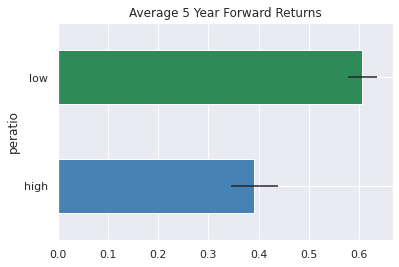

In [31]:
# Create two series with 5 yr forward returns during high and low PE ratio
high_pe = df.five_yr_fr[df['peratio'] == 'high']
low_pe = df.five_yr_fr[df['peratio'] == 'low']

# Run two sample t-test
result1 = ttest(low_pe, high_pe)
print(colored(result1, 'green', attrs=['bold']))

pd.merge(low_pe.describe(), high_pe.describe(), left_index=True, right_index=True, suffixes=('_low_pe', '_high_pe'))

# Create error bars
df1 = df[['peratio','five_yr_fr']].copy()
options = ['low','high']
df1 = df[df['peratio'].isin(options)]

def double_std(array):
    return np.std(array) * 2
         
returns =df1.groupby("peratio").agg([np.mean, double_std, sp.sem])
returns =returns["five_yr_fr"]
returns.plot(kind ="barh", y = "mean", legend = False, title = "Average 5 Year Forward Returns", xerr = "sem", color = ["steelblue","seagreen"])

# Calculate the sample size, mean, and variance of each sample to calculate standard errors.
sample_1_n = low_pe.shape[0]
sample_2_n = high_pe.shape[0]
sample_1_mean = low_pe.mean()
sample_2_mean = high_pe.mean()
sample_1_var = low_pe.var()
sample_2_var = high_pe.var()

# Calculate the standard error and compute the confidence intervals.
def get_95_ci(array_1, array_2):
    sample_1_n = array_1.shape[0]
    sample_2_n = array_2.shape[0]
    sample_1_mean = array_1.mean()
    sample_2_mean = array_2.mean()
    sample_1_var = array_1.var()
    sample_2_var = array_2.var()
    mean_difference = sample_2_mean - sample_1_mean
    std_err_difference = math.sqrt((sample_1_var/sample_1_n)+(sample_2_var/sample_2_n))
    margin_of_error = 1.96 * std_err_difference
    ci_lower = mean_difference - margin_of_error
    ci_upper = mean_difference + margin_of_error
    return("The difference in means at the 95% confidence interval (two-tail) is between "+str(ci_lower)+" and "+str(ci_upper)+".")

get_95_ci(low_pe,high_pe)


#### **t-Test Conclusion**
Reject the null hypothesis that the mean 5-year forward return for S&P 500 during low PE ratio = The mean 5-year forward return for S&P 500 during low PE ratio.

The difference is 4.13 standard deviations between means of 5-year forward returns for low PE ratio and high PE ratio. This difference is statistically significant with the p-value of less than 0.05 



#### **ii) 10-year Treasury Yield**


Ttest_indResult(statistic=-2.945020383205991, pvalue=0.0033488225823419247)


,five_yr_fr_increasingDGS10,five_yr_fr_decreasing_DGS10
count,324.000000,306.000000
mean,0.401793,0.516815
std,0.500950,0.478033
min,-0.326385,-0.213776
25%,0.002737,0.090810
50%,0.375864,0.539436
75%,0.667458,0.799419
max,2.138645,2.002735


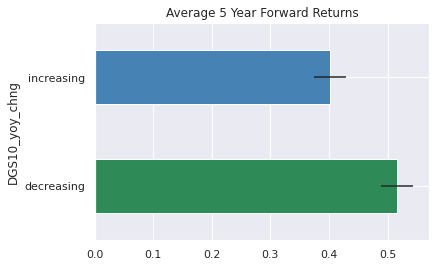

In [43]:
# Create two series with 5 yr forward returns during high and low PE ratio
increasing_dgs10 = df.five_yr_fr[df['DGS10_yoy_chng'] == 'increasing']
decreasing_dgs10  = df.five_yr_fr[df['DGS10_yoy_chng'] == 'decreasing']

# Run two sample t-test
result2 = ttest(increasing_dgs10, decreasing_dgs10)
print(colored(result2, 'green', attrs=['bold']))

pd.merge(increasing_dgs10.describe(), decreasing_dgs10.describe(), left_index=True, right_index=True, suffixes=('_increasingDGS10', '_decreasing_DGS10'))

# Create error bars
df1 = df[['DGS10_yoy_chng','five_yr_fr']].copy()
options = ['increasing','decreasing']
df1 = df[df['DGS10_yoy_chng'].isin(options)]
         
returns =df1.groupby("DGS10_yoy_chng").agg([np.mean, double_std, sp.sem])
returns =returns["five_yr_fr"]
returns.plot(kind ="barh", y = "mean", legend = False, title = "Average 5 Year Forward Returns", xerr = "sem", color = ["seagreen","steelblue"])


# Calculate the sample size, mean, and variance of each sample to calculate standard errors.
sample_1_n = increasing_dgs10.shape[0]
sample_2_n = decreasing_dgs10.shape[0]
sample_1_mean = increasing_dgs10.mean()
sample_2_mean = decreasing_dgs10.mean()
sample_1_var = increasing_dgs10.var()
sample_2_var = decreasing_dgs10.var()

# Calculate the standard error and compute the confidence intervals.
def get_95_ci(array_1, array_2):
    sample_1_n = array_1.shape[0]
    sample_2_n = array_2.shape[0]
    sample_1_mean = array_1.mean()
    sample_2_mean = array_2.mean()
    sample_1_var = array_1.var()
    sample_2_var = array_2.var()
    mean_difference = sample_2_mean - sample_1_mean
    std_err_difference = math.sqrt((sample_1_var/sample_1_n)+(sample_2_var/sample_2_n))
    margin_of_error = 1.96 * std_err_difference
    ci_lower = mean_difference - margin_of_error
    ci_upper = mean_difference + margin_of_error
    return("The difference in means at the 95% confidence interval (two-tail) is between "+str(ci_lower)+" and "+str(ci_upper)+".")


#### **t-Test Conclusion**
Reject the null hypothesis that The mean 5-year forward return for S&P 500 during increasing 10-year treasury yield = The mean 5-year forward return for S&P 500 during decreasing 10-year treasury yield.

The difference is 2.94 standard deviations between means of 5-year forward returns for increasing 10-year treasury yield  and decreasing 10-year treasury yield. This difference is statistically significaant with the p-value of less than 0.05 



## **Summary & Recommendations**

#### **When is the optimal time to invest in S&P 500 for investors with 5-year investment horizon?**

Inferring from the results of out t-Tests, we can safely say that investing when S&P 500's PE ratio is low rather than when it is high has yeilded higher returns 95% of the time. The difference in mean returns being 21% higher.
Similarly, we can also deduce that investing in S&P 500 when 10-year Treasury yileds are in a decreasing trend (year-over-year) yileds higher returns 95% of the time. The difference in mean returns here being 11% higher.

#### **Recommendations:**

Given the conclusion reach, the study would recommend investors invest/invest more when PE ratio is less than or equal to 14 and/or 10-year Treasury yeilds are decreasing on a year-over-year basis. More specifially, this study provides sufficient evidence against Dollar Cost Averaging (DCA) investment, wherein an investor allocates a set amount of money at regular intervals, usually shorter than a year (monthly or quarterly). Futhermore, it provides strong evidence for lump-sum investing based on PE ratio and trend of 10-year Treasury yields. One can even take it a step further by modifying the DCA and increasing the amount invested while PE ratio is low and/or 10-year Treasury yeilds are trending lower, and vice-versa.
